In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
rootPath = os.getcwd()+ os.sep
if os.path.exists("data"): # automatically recognize
    rootPath += "data" + os.sep
elif os.path.exists("dataset"):
    rootPath += "dataset" + os.sep
else:
    rootPath += input("Relative Folder: ").replace("\"", "").replace("\'", "").replace(os.sep, "") + os.sep
#for dirname, _, filenames in os.walk(rootPath):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
classes = []
for i in os.listdir(rootPath):
    if os.path.isdir(rootPath + i) and not i.startswith("#"):
        classes.append(i)
    assert(i.lower() != ".ipynb_checkpoints")
classes = tuple(classes)
print(classes)
class_count = len(classes)
assert(class_count > 0)
useNet = 50
plt_color = "green"
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

('01_PositiveID', '02_NegativeID', '03_Unverified', '04_Unprocessed')


In [2]:
#['resnet18', 'resnet34'， 'resnet50'， 'resnet101', 'resnet152']
if useNet == 18:
    from torchvision.models.resnet import resnet18
    resnet = resnet18(pretrained = True)
elif useNet == 34:
    from torchvision.models.resnet import resnet34
    resnet = resnet34(pretrained = True)
elif useNet == 50:
    from torchvision.models.resnet import resnet50
    resnet = resnet50(pretrained = True)
elif useNet == 101:
    from torchvision.models.resnet import resnet101
    resnet = resnet101(pretrained = True)
elif useNet == 152:
    from torchvision.models.resnet import resnet152
    resnet = resnet152(pretrained = True)
else:
    raise ModuleNotFoundError

import random
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import *
import torchvision.transforms as transforms
import datetime

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import  SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from time import sleep

In [4]:
# Processing of data set and training set
if useNet == 18 or useNet == 34:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.5)
elif useNet == 50 or useNet == 101 or useNet == 152:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.4)
else:
    raise ModuleNotFoundError

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # resize to 256x256
    PIL_transform,
    transforms.RandomCrop((225, 225)),  # randomly cut to 224x224
    #transforms.RandomHorizontalFlip(),  # flip horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))  # Normalization, the value is given by Imagenet
])
 
# Processing of data set verification set
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU is better than CPU
cell_dataset = datasets.ImageFolder(root = rootPath, transform = transform_train)

#define dataloader
dataset_loader = DataLoader(cell_dataset, batch_size = 16, shuffle = True, num_workers = 4)

split1 = int(0.1 * len(cell_dataset))
split2 = int(0.9 * len(cell_dataset))
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
test_idx = index_list[:split1] + index_list[split2:]
train_idx = index_list[split1:split2]

## create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(test_idx)
#trainset=cell_dataset[split1:split2]

## create iterator objects for train and valid datasets
trainloader = DataLoader(cell_dataset, batch_size = 16, sampler = tr_sampler,num_workers = 4)
validloader = DataLoader(cell_dataset, batch_size = 16, sampler = val_sampler,num_workers = 4)

In [5]:
print(device)

cuda


In [6]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total
 
def train(epoch):
    print('\nEpoch: %d' % epoch)
    #scheduler.step()
    model.train()
    train_acc = 0.0
    for batch_idx, (img, label) in enumerate(trainloader):
        image = img.to(device)
        label = label.to(device)
        optimizer2.zero_grad()
        out = model(image)
        #print('out:{}'.format(out))
        #print(out.shape)
        #print('label:{}'.format(label))
        loss = criterion(out, label)
        loss.backward()
        optimizer2.step()
        train_acc = get_acc(out, label)
        print("Epoch:%d [%d|%d] loss:%f acc:%f" % (epoch, batch_idx, len(trainloader), loss.mean(), train_acc))
    scheduler.step()
 
 
def val(epoch):
    print("\nValidation Epoch: %d" % epoch)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (img, label) in enumerate(validloader):
            image = img.to(device)
            label = label.to(device)
            out = model(image)
            _, predicted = torch.max(out.data, 1)
            total += image.size(0)
            correct += predicted.data.eq(label.data).cpu().sum()
    print("Acc: %f " % ((1.0 * correct.numpy()) / total))
    return (1.0 * correct.numpy()) / total
 
 
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 5, stride = 2, padding = 2, bias = False)
        self.resnet_layer = nn.Sequential(*list(model.children())[1:-1])# Remove the last layer of the model
        if useNet == 18 or useNet == 34:
            self.Linear_layer = nn.Linear(512, 8) # Add a full connection layer with modified parameters
        elif useNet == 50 or useNet == 101 or useNet == 152:
            self.Linear_layer = nn.Linear(2048, 32) # Add a full connection layer with modified parameters
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x

In [7]:
# train
model = Net(resnet)
model = model.to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.8, weight_decay = 3e-3) # Set training details
optimizer2 = optim.Adam(model.parameters(), lr = 1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay = 5e-4, amsgrad = True)
scheduler = StepLR(optimizer2, step_size = 4, gamma = 0.3)
criterion = nn.CrossEntropyLoss()

epochs = 14
if useNet == 18:
    epochs = 24
elif useNet == 34:
    epochs = 14
elif useNet == 50:
    epochs = 18

pauseTime = 10 # to have a rest, e.g. 10s, 30s, 60s, 0 for no rests
assert((type(pauseTime) == int or type(pauseTime) == float) and pauseTime >= 0)
results_x = [epoch for epoch in range(epochs)]
startTime = datetime.datetime.now()
results_y = []
for epoch in range(epochs):
    train(epoch)
    results_y.append(val(epoch))
    if epoch != epochs - 1:
        sleep(pauseTime)
endTime = datetime.datetime.now()


Epoch: 0
Epoch:0 [0|160] loss:4.137541 acc:0.000000
Epoch:0 [1|160] loss:3.889085 acc:0.000000
Epoch:0 [2|160] loss:3.674046 acc:0.000000
Epoch:0 [3|160] loss:3.458415 acc:0.000000
Epoch:0 [4|160] loss:3.234106 acc:0.062500
Epoch:0 [5|160] loss:3.022512 acc:0.312500
Epoch:0 [6|160] loss:2.787782 acc:0.687500
Epoch:0 [7|160] loss:2.564481 acc:0.750000
Epoch:0 [8|160] loss:2.294174 acc:0.875000
Epoch:0 [9|160] loss:2.120922 acc:0.937500
Epoch:0 [10|160] loss:1.936488 acc:0.937500
Epoch:0 [11|160] loss:1.844241 acc:0.875000
Epoch:0 [12|160] loss:1.446784 acc:1.000000
Epoch:0 [13|160] loss:1.248541 acc:1.000000
Epoch:0 [14|160] loss:1.309708 acc:0.875000
Epoch:0 [15|160] loss:0.853637 acc:0.937500
Epoch:0 [16|160] loss:0.669588 acc:1.000000
Epoch:0 [17|160] loss:0.545931 acc:1.000000
Epoch:0 [18|160] loss:0.469861 acc:1.000000
Epoch:0 [19|160] loss:0.389025 acc:1.000000
Epoch:0 [20|160] loss:0.329013 acc:1.000000
Epoch:0 [21|160] loss:0.520338 acc:0.937500
Epoch:0 [22|160] loss:0.211052 a

Epoch:1 [25|160] loss:0.055335 acc:1.000000
Epoch:1 [26|160] loss:0.049942 acc:1.000000
Epoch:1 [27|160] loss:0.045870 acc:1.000000
Epoch:1 [28|160] loss:0.205977 acc:0.937500
Epoch:1 [29|160] loss:0.053562 acc:1.000000
Epoch:1 [30|160] loss:0.045035 acc:1.000000
Epoch:1 [31|160] loss:0.039582 acc:1.000000
Epoch:1 [32|160] loss:0.036245 acc:1.000000
Epoch:1 [33|160] loss:0.678136 acc:0.875000
Epoch:1 [34|160] loss:0.037300 acc:1.000000
Epoch:1 [35|160] loss:0.035198 acc:1.000000
Epoch:1 [36|160] loss:0.038468 acc:1.000000
Epoch:1 [37|160] loss:0.032223 acc:1.000000
Epoch:1 [38|160] loss:0.321024 acc:0.937500
Epoch:1 [39|160] loss:0.035224 acc:1.000000
Epoch:1 [40|160] loss:0.345980 acc:0.937500
Epoch:1 [41|160] loss:0.030737 acc:1.000000
Epoch:1 [42|160] loss:0.030974 acc:1.000000
Epoch:1 [43|160] loss:0.303636 acc:0.937500
Epoch:1 [44|160] loss:0.028531 acc:1.000000
Epoch:1 [45|160] loss:1.073482 acc:0.812500
Epoch:1 [46|160] loss:0.029930 acc:1.000000
Epoch:1 [47|160] loss:0.534168 a

Epoch:2 [50|160] loss:0.045019 acc:1.000000
Epoch:2 [51|160] loss:0.031034 acc:1.000000
Epoch:2 [52|160] loss:0.034788 acc:1.000000
Epoch:2 [53|160] loss:0.037375 acc:1.000000
Epoch:2 [54|160] loss:0.212079 acc:0.937500
Epoch:2 [55|160] loss:0.037544 acc:1.000000
Epoch:2 [56|160] loss:0.030943 acc:1.000000
Epoch:2 [57|160] loss:0.033247 acc:1.000000
Epoch:2 [58|160] loss:0.223271 acc:0.937500
Epoch:2 [59|160] loss:0.025191 acc:1.000000
Epoch:2 [60|160] loss:0.230001 acc:0.937500
Epoch:2 [61|160] loss:0.024541 acc:1.000000
Epoch:2 [62|160] loss:0.221786 acc:0.937500
Epoch:2 [63|160] loss:0.024602 acc:1.000000
Epoch:2 [64|160] loss:0.524422 acc:0.875000
Epoch:2 [65|160] loss:0.023065 acc:1.000000
Epoch:2 [66|160] loss:0.032522 acc:1.000000
Epoch:2 [67|160] loss:0.030283 acc:1.000000
Epoch:2 [68|160] loss:0.221135 acc:0.937500
Epoch:2 [69|160] loss:0.030454 acc:1.000000
Epoch:2 [70|160] loss:0.322632 acc:0.937500
Epoch:2 [71|160] loss:0.743581 acc:0.875000
Epoch:2 [72|160] loss:0.399380 a

Epoch:3 [75|160] loss:0.073244 acc:1.000000
Epoch:3 [76|160] loss:0.052391 acc:1.000000
Epoch:3 [77|160] loss:0.042975 acc:1.000000
Epoch:3 [78|160] loss:0.043832 acc:1.000000
Epoch:3 [79|160] loss:0.232213 acc:0.937500
Epoch:3 [80|160] loss:0.029559 acc:1.000000
Epoch:3 [81|160] loss:0.029475 acc:1.000000
Epoch:3 [82|160] loss:0.038979 acc:1.000000
Epoch:3 [83|160] loss:0.343589 acc:0.875000
Epoch:3 [84|160] loss:0.039466 acc:1.000000
Epoch:3 [85|160] loss:0.035878 acc:1.000000
Epoch:3 [86|160] loss:0.508083 acc:0.937500
Epoch:3 [87|160] loss:0.520225 acc:0.937500
Epoch:3 [88|160] loss:0.031463 acc:1.000000
Epoch:3 [89|160] loss:0.343077 acc:0.937500
Epoch:3 [90|160] loss:0.026218 acc:1.000000
Epoch:3 [91|160] loss:0.231603 acc:0.937500
Epoch:3 [92|160] loss:0.030820 acc:1.000000
Epoch:3 [93|160] loss:0.020917 acc:1.000000
Epoch:3 [94|160] loss:0.806829 acc:0.875000
Epoch:3 [95|160] loss:0.026140 acc:1.000000
Epoch:3 [96|160] loss:0.198774 acc:0.937500
Epoch:3 [97|160] loss:0.028662 a

Epoch:4 [100|160] loss:0.334250 acc:0.937500
Epoch:4 [101|160] loss:0.029573 acc:1.000000
Epoch:4 [102|160] loss:0.027427 acc:1.000000
Epoch:4 [103|160] loss:0.232132 acc:0.937500
Epoch:4 [104|160] loss:0.037458 acc:1.000000
Epoch:4 [105|160] loss:0.030318 acc:1.000000
Epoch:4 [106|160] loss:0.026197 acc:1.000000
Epoch:4 [107|160] loss:0.025568 acc:1.000000
Epoch:4 [108|160] loss:0.037354 acc:1.000000
Epoch:4 [109|160] loss:0.263037 acc:0.937500
Epoch:4 [110|160] loss:0.022697 acc:1.000000
Epoch:4 [111|160] loss:0.207889 acc:0.937500
Epoch:4 [112|160] loss:0.160752 acc:0.937500
Epoch:4 [113|160] loss:0.025889 acc:1.000000
Epoch:4 [114|160] loss:0.078402 acc:0.937500
Epoch:4 [115|160] loss:0.026145 acc:1.000000
Epoch:4 [116|160] loss:0.110150 acc:0.937500
Epoch:4 [117|160] loss:0.023457 acc:1.000000
Epoch:4 [118|160] loss:0.290358 acc:0.937500
Epoch:4 [119|160] loss:0.053802 acc:1.000000
Epoch:4 [120|160] loss:0.028343 acc:1.000000
Epoch:4 [121|160] loss:0.292856 acc:0.937500
Epoch:4 [1

Epoch:5 [124|160] loss:0.198822 acc:0.937500
Epoch:5 [125|160] loss:0.282783 acc:0.937500
Epoch:5 [126|160] loss:0.240042 acc:0.937500
Epoch:5 [127|160] loss:0.084421 acc:1.000000
Epoch:5 [128|160] loss:0.033121 acc:1.000000
Epoch:5 [129|160] loss:0.018051 acc:1.000000
Epoch:5 [130|160] loss:0.028907 acc:1.000000
Epoch:5 [131|160] loss:0.388883 acc:0.937500
Epoch:5 [132|160] loss:0.325399 acc:0.937500
Epoch:5 [133|160] loss:0.024987 acc:1.000000
Epoch:5 [134|160] loss:0.019921 acc:1.000000
Epoch:5 [135|160] loss:0.363078 acc:0.937500
Epoch:5 [136|160] loss:0.049547 acc:1.000000
Epoch:5 [137|160] loss:0.029779 acc:1.000000
Epoch:5 [138|160] loss:0.038758 acc:1.000000
Epoch:5 [139|160] loss:0.023361 acc:1.000000
Epoch:5 [140|160] loss:0.027204 acc:1.000000
Epoch:5 [141|160] loss:0.022423 acc:1.000000
Epoch:5 [142|160] loss:0.512216 acc:0.875000
Epoch:5 [143|160] loss:0.020993 acc:1.000000
Epoch:5 [144|160] loss:0.265988 acc:0.875000
Epoch:5 [145|160] loss:0.353521 acc:0.937500
Epoch:5 [1

Epoch:6 [148|160] loss:0.191812 acc:0.937500
Epoch:6 [149|160] loss:0.241805 acc:0.937500
Epoch:6 [150|160] loss:0.380401 acc:0.875000
Epoch:6 [151|160] loss:0.120420 acc:0.937500
Epoch:6 [152|160] loss:0.022403 acc:1.000000
Epoch:6 [153|160] loss:0.026113 acc:1.000000
Epoch:6 [154|160] loss:0.044236 acc:1.000000
Epoch:6 [155|160] loss:0.094823 acc:0.937500
Epoch:6 [156|160] loss:0.042930 acc:1.000000
Epoch:6 [157|160] loss:0.377687 acc:0.875000
Epoch:6 [158|160] loss:0.153733 acc:0.875000
Epoch:6 [159|160] loss:0.047745 acc:1.000000

Validation Epoch: 6
Acc: 0.956182 

Epoch: 7
Epoch:7 [0|160] loss:0.372273 acc:0.875000
Epoch:7 [1|160] loss:0.088287 acc:0.937500
Epoch:7 [2|160] loss:0.068868 acc:1.000000
Epoch:7 [3|160] loss:0.141231 acc:0.937500
Epoch:7 [4|160] loss:0.567156 acc:0.750000
Epoch:7 [5|160] loss:0.277508 acc:0.937500
Epoch:7 [6|160] loss:0.111201 acc:0.937500
Epoch:7 [7|160] loss:0.535020 acc:0.875000
Epoch:7 [8|160] loss:0.045546 acc:1.000000
Epoch:7 [9|160] loss:0.2180

Epoch:8 [11|160] loss:0.045835 acc:1.000000
Epoch:8 [12|160] loss:0.022698 acc:1.000000
Epoch:8 [13|160] loss:0.028948 acc:1.000000
Epoch:8 [14|160] loss:0.023481 acc:1.000000
Epoch:8 [15|160] loss:0.044413 acc:1.000000
Epoch:8 [16|160] loss:0.079900 acc:0.937500
Epoch:8 [17|160] loss:0.066452 acc:0.937500
Epoch:8 [18|160] loss:0.030834 acc:1.000000
Epoch:8 [19|160] loss:0.032351 acc:1.000000
Epoch:8 [20|160] loss:0.040817 acc:1.000000
Epoch:8 [21|160] loss:0.037403 acc:1.000000
Epoch:8 [22|160] loss:0.039987 acc:1.000000
Epoch:8 [23|160] loss:0.023223 acc:1.000000
Epoch:8 [24|160] loss:0.046232 acc:1.000000
Epoch:8 [25|160] loss:0.211072 acc:0.937500
Epoch:8 [26|160] loss:0.104849 acc:0.937500
Epoch:8 [27|160] loss:0.160764 acc:0.937500
Epoch:8 [28|160] loss:0.401005 acc:0.875000
Epoch:8 [29|160] loss:0.014646 acc:1.000000
Epoch:8 [30|160] loss:0.132567 acc:0.875000
Epoch:8 [31|160] loss:0.213627 acc:0.875000
Epoch:8 [32|160] loss:0.024862 acc:1.000000
Epoch:8 [33|160] loss:0.057273 a

Epoch:9 [36|160] loss:0.015256 acc:1.000000
Epoch:9 [37|160] loss:0.019117 acc:1.000000
Epoch:9 [38|160] loss:0.022695 acc:1.000000
Epoch:9 [39|160] loss:0.153873 acc:0.875000
Epoch:9 [40|160] loss:0.068678 acc:0.937500
Epoch:9 [41|160] loss:0.022710 acc:1.000000
Epoch:9 [42|160] loss:0.188775 acc:0.937500
Epoch:9 [43|160] loss:0.017435 acc:1.000000
Epoch:9 [44|160] loss:0.019552 acc:1.000000
Epoch:9 [45|160] loss:0.008456 acc:1.000000
Epoch:9 [46|160] loss:0.015009 acc:1.000000
Epoch:9 [47|160] loss:0.125884 acc:0.937500
Epoch:9 [48|160] loss:0.022961 acc:1.000000
Epoch:9 [49|160] loss:0.035706 acc:1.000000
Epoch:9 [50|160] loss:0.015732 acc:1.000000
Epoch:9 [51|160] loss:0.012065 acc:1.000000
Epoch:9 [52|160] loss:0.118173 acc:0.937500
Epoch:9 [53|160] loss:0.019158 acc:1.000000
Epoch:9 [54|160] loss:0.037576 acc:1.000000
Epoch:9 [55|160] loss:0.348260 acc:0.937500
Epoch:9 [56|160] loss:0.024832 acc:1.000000
Epoch:9 [57|160] loss:0.015307 acc:1.000000
Epoch:9 [58|160] loss:0.017599 a

Epoch:10 [59|160] loss:0.097131 acc:0.937500
Epoch:10 [60|160] loss:0.032680 acc:1.000000
Epoch:10 [61|160] loss:0.009181 acc:1.000000
Epoch:10 [62|160] loss:0.022839 acc:1.000000
Epoch:10 [63|160] loss:0.012576 acc:1.000000
Epoch:10 [64|160] loss:0.185452 acc:0.937500
Epoch:10 [65|160] loss:0.038509 acc:1.000000
Epoch:10 [66|160] loss:0.007831 acc:1.000000
Epoch:10 [67|160] loss:0.012039 acc:1.000000
Epoch:10 [68|160] loss:0.183998 acc:0.937500
Epoch:10 [69|160] loss:0.016813 acc:1.000000
Epoch:10 [70|160] loss:0.139643 acc:0.937500
Epoch:10 [71|160] loss:0.052636 acc:0.937500
Epoch:10 [72|160] loss:0.018568 acc:1.000000
Epoch:10 [73|160] loss:0.026950 acc:1.000000
Epoch:10 [74|160] loss:0.026327 acc:1.000000
Epoch:10 [75|160] loss:0.011972 acc:1.000000
Epoch:10 [76|160] loss:0.011586 acc:1.000000
Epoch:10 [77|160] loss:0.046805 acc:1.000000
Epoch:10 [78|160] loss:0.067594 acc:0.937500
Epoch:10 [79|160] loss:0.013066 acc:1.000000
Epoch:10 [80|160] loss:0.084999 acc:1.000000
Epoch:10 [

Epoch:11 [79|160] loss:0.033423 acc:1.000000
Epoch:11 [80|160] loss:0.025449 acc:1.000000
Epoch:11 [81|160] loss:0.009978 acc:1.000000
Epoch:11 [82|160] loss:0.011489 acc:1.000000
Epoch:11 [83|160] loss:0.016865 acc:1.000000
Epoch:11 [84|160] loss:0.015740 acc:1.000000
Epoch:11 [85|160] loss:0.019741 acc:1.000000
Epoch:11 [86|160] loss:0.011967 acc:1.000000
Epoch:11 [87|160] loss:0.099736 acc:0.937500
Epoch:11 [88|160] loss:0.124298 acc:0.937500
Epoch:11 [89|160] loss:0.017736 acc:1.000000
Epoch:11 [90|160] loss:0.098877 acc:0.937500
Epoch:11 [91|160] loss:0.016379 acc:1.000000
Epoch:11 [92|160] loss:0.033091 acc:1.000000
Epoch:11 [93|160] loss:0.035587 acc:1.000000
Epoch:11 [94|160] loss:0.059829 acc:0.937500
Epoch:11 [95|160] loss:0.012149 acc:1.000000
Epoch:11 [96|160] loss:0.012813 acc:1.000000
Epoch:11 [97|160] loss:0.019863 acc:1.000000
Epoch:11 [98|160] loss:0.128491 acc:0.937500
Epoch:11 [99|160] loss:0.210962 acc:0.875000
Epoch:11 [100|160] loss:0.281315 acc:0.937500
Epoch:11 

Epoch:12 [99|160] loss:0.013686 acc:1.000000
Epoch:12 [100|160] loss:0.012134 acc:1.000000
Epoch:12 [101|160] loss:0.028105 acc:1.000000
Epoch:12 [102|160] loss:0.247902 acc:0.937500
Epoch:12 [103|160] loss:0.071599 acc:0.937500
Epoch:12 [104|160] loss:0.026895 acc:1.000000
Epoch:12 [105|160] loss:0.042253 acc:1.000000
Epoch:12 [106|160] loss:0.017083 acc:1.000000
Epoch:12 [107|160] loss:0.011895 acc:1.000000
Epoch:12 [108|160] loss:0.032139 acc:1.000000
Epoch:12 [109|160] loss:0.026253 acc:1.000000
Epoch:12 [110|160] loss:0.036266 acc:1.000000
Epoch:12 [111|160] loss:0.012175 acc:1.000000
Epoch:12 [112|160] loss:0.023974 acc:1.000000
Epoch:12 [113|160] loss:0.016182 acc:1.000000
Epoch:12 [114|160] loss:0.023551 acc:1.000000
Epoch:12 [115|160] loss:0.038861 acc:1.000000
Epoch:12 [116|160] loss:0.124762 acc:0.937500
Epoch:12 [117|160] loss:0.010450 acc:1.000000
Epoch:12 [118|160] loss:0.015293 acc:1.000000
Epoch:12 [119|160] loss:0.206042 acc:0.937500
Epoch:12 [120|160] loss:0.015616 ac

Epoch:13 [119|160] loss:0.020153 acc:1.000000
Epoch:13 [120|160] loss:0.009943 acc:1.000000
Epoch:13 [121|160] loss:0.054235 acc:1.000000
Epoch:13 [122|160] loss:0.033386 acc:1.000000
Epoch:13 [123|160] loss:0.058126 acc:0.937500
Epoch:13 [124|160] loss:0.018239 acc:1.000000
Epoch:13 [125|160] loss:0.010389 acc:1.000000
Epoch:13 [126|160] loss:0.011517 acc:1.000000
Epoch:13 [127|160] loss:0.016887 acc:1.000000
Epoch:13 [128|160] loss:0.020930 acc:1.000000
Epoch:13 [129|160] loss:0.010798 acc:1.000000
Epoch:13 [130|160] loss:0.008438 acc:1.000000
Epoch:13 [131|160] loss:0.014386 acc:1.000000
Epoch:13 [132|160] loss:0.011521 acc:1.000000
Epoch:13 [133|160] loss:0.015489 acc:1.000000
Epoch:13 [134|160] loss:0.016399 acc:1.000000
Epoch:13 [135|160] loss:0.024929 acc:1.000000
Epoch:13 [136|160] loss:0.134357 acc:0.937500
Epoch:13 [137|160] loss:0.012082 acc:1.000000
Epoch:13 [138|160] loss:0.011024 acc:1.000000
Epoch:13 [139|160] loss:0.147549 acc:0.937500
Epoch:13 [140|160] loss:0.011942 a

Epoch:14 [139|160] loss:0.028091 acc:1.000000
Epoch:14 [140|160] loss:0.095746 acc:0.937500
Epoch:14 [141|160] loss:0.014213 acc:1.000000
Epoch:14 [142|160] loss:0.104938 acc:0.937500
Epoch:14 [143|160] loss:0.010443 acc:1.000000
Epoch:14 [144|160] loss:0.013091 acc:1.000000
Epoch:14 [145|160] loss:0.016805 acc:1.000000
Epoch:14 [146|160] loss:0.042612 acc:1.000000
Epoch:14 [147|160] loss:0.033264 acc:1.000000
Epoch:14 [148|160] loss:0.021353 acc:1.000000
Epoch:14 [149|160] loss:0.008968 acc:1.000000
Epoch:14 [150|160] loss:0.030627 acc:1.000000
Epoch:14 [151|160] loss:0.243287 acc:0.937500
Epoch:14 [152|160] loss:0.016512 acc:1.000000
Epoch:14 [153|160] loss:0.020726 acc:1.000000
Epoch:14 [154|160] loss:0.015992 acc:1.000000
Epoch:14 [155|160] loss:0.013911 acc:1.000000
Epoch:14 [156|160] loss:0.008621 acc:1.000000
Epoch:14 [157|160] loss:0.037359 acc:1.000000
Epoch:14 [158|160] loss:0.043058 acc:1.000000
Epoch:14 [159|160] loss:0.009841 acc:1.000000

Validation Epoch: 14
Acc: 0.97026

Epoch:15 [159|160] loss:0.008568 acc:1.000000

Validation Epoch: 15
Acc: 0.973396 

Epoch: 16
Epoch:16 [0|160] loss:0.031683 acc:1.000000
Epoch:16 [1|160] loss:0.013251 acc:1.000000
Epoch:16 [2|160] loss:0.007385 acc:1.000000
Epoch:16 [3|160] loss:0.030781 acc:1.000000
Epoch:16 [4|160] loss:0.014942 acc:1.000000
Epoch:16 [5|160] loss:0.018223 acc:1.000000
Epoch:16 [6|160] loss:0.010329 acc:1.000000
Epoch:16 [7|160] loss:0.033916 acc:1.000000
Epoch:16 [8|160] loss:0.035492 acc:1.000000
Epoch:16 [9|160] loss:0.018873 acc:1.000000
Epoch:16 [10|160] loss:0.012699 acc:1.000000
Epoch:16 [11|160] loss:0.055862 acc:0.937500
Epoch:16 [12|160] loss:0.009998 acc:1.000000
Epoch:16 [13|160] loss:0.017654 acc:1.000000
Epoch:16 [14|160] loss:0.008373 acc:1.000000
Epoch:16 [15|160] loss:0.007118 acc:1.000000
Epoch:16 [16|160] loss:0.008349 acc:1.000000
Epoch:16 [17|160] loss:0.012351 acc:1.000000
Epoch:16 [18|160] loss:0.037682 acc:1.000000
Epoch:16 [19|160] loss:0.014881 acc:1.000000
Epoch:16 [20|160

Epoch:17 [19|160] loss:0.022638 acc:1.000000
Epoch:17 [20|160] loss:0.062127 acc:0.937500
Epoch:17 [21|160] loss:0.011461 acc:1.000000
Epoch:17 [22|160] loss:0.011599 acc:1.000000
Epoch:17 [23|160] loss:0.005426 acc:1.000000
Epoch:17 [24|160] loss:0.007857 acc:1.000000
Epoch:17 [25|160] loss:0.041190 acc:1.000000
Epoch:17 [26|160] loss:0.012628 acc:1.000000
Epoch:17 [27|160] loss:0.011809 acc:1.000000
Epoch:17 [28|160] loss:0.014634 acc:1.000000
Epoch:17 [29|160] loss:0.016831 acc:1.000000
Epoch:17 [30|160] loss:0.010155 acc:1.000000
Epoch:17 [31|160] loss:0.006152 acc:1.000000
Epoch:17 [32|160] loss:0.021508 acc:1.000000
Epoch:17 [33|160] loss:0.231054 acc:0.937500
Epoch:17 [34|160] loss:0.043510 acc:1.000000
Epoch:17 [35|160] loss:0.087096 acc:0.937500
Epoch:17 [36|160] loss:0.017692 acc:1.000000
Epoch:17 [37|160] loss:0.019328 acc:1.000000
Epoch:17 [38|160] loss:0.008789 acc:1.000000
Epoch:17 [39|160] loss:0.008038 acc:1.000000
Epoch:17 [40|160] loss:0.015814 acc:1.000000
Epoch:17 [

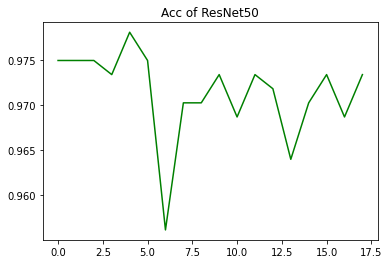

max_acc: 97.80907668231612%, epoch: 4, time: 454.701217s


d:\program files\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\program files\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\program files\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\program files\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\pro

In [8]:
plt.title("Acc of ResNet" + str(useNet))
plt.plot(results_x, results_y, color = plt_color)
plt.show()
with open(rootPath + "data.txt", "a", encoding = "utf-8") as f:
    f.write(str({useNet:[results_x, results_y]}) + "\n")
print("max_acc: {0}%, epoch: {1}, time: {2:.6f}s".format(max(results_y) * 100, results_y.index(max(results_y)),\
    ((endTime - startTime).total_seconds() - pauseTime * epochs) * (results_y.index(max(results_y)) + 1) / (epochs - 1)))
torch.save(model, 'modelcatdog.pth') # save model

In [9]:
model = torch.load('modelcatdog.pth') # load model

In [10]:
if torch.cuda.is_available():
    model = torch.load('modelcatdog.pth')
else:
    model = torch.load('modelcatdog.pth', map_location = 'cpu')
model.cpu()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (resnet_layer): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [11]:
# verification
class_correct = list(0. for i in range(class_count))
class_total = list(0. for i in range(class_count))
class_rate = list(0. for i in range(class_count))
F1_rate = list(0. for i in range(class_count))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(class_count):
            label = labels[i]
            try:
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except IndexError:
                pass
        #print(class_correct, class_total)

for i in range(class_count):
    if class_total[i] == 0:
        if sum(class_total) == 0:
            print("This model is not available on the questions you are trying to solve.")
        else:
            print("Average maximum accuracy: %.2f %%" % (100 * sum(class_correct) / sum(class_total)))
        break
else: # naturally break
    for i in range(class_count):
        print("Number of correct:", class_correct[i], "Number of total:", class_total[i])
        class_rate[i] = class_correct[i] / class_total[i]
        print("Accuracy of %5s : %.2f %%" % (classes[i], class_rate[i] * 100))
        F1_rate[i] = 1 / class_rate[i]
    print("F1 Score: %.2f %%" % (class_count / sum(F1_rate)))

Average maximum accuracy: 96.25 %
